In [34]:
# Imports
import sys
import numpy as np

%cd Q:\sachuriga\Sachuriga_Python\cnn-ripple-main\src\notebooks
sys.path.insert(1, r'Q:\sachuriga\Sachuriga_Python\cnn-ripple-main\src\cnn')

Q:\sachuriga\Sachuriga_Python\cnn-ripple-main\src\notebooks


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
file_path = r"Q:\sachuriga\Sachuriga_Python/quattrocolo-nwb4fp/ASSY-236-F.prb"

# Read the file and parse the dictionary
local_vars = {'np': np}
with open(file_path, 'r') as file:
    exec(file.read(), local_vars)  # Execute the file content with NumPy in scope

    
channel_groups = local_vars.get('channel_groups')
if channel_groups is None:
    raise ValueError(f"'channel_groups' not found in {file_path}")

# Assuming channel_groups is loaded from Step 1
data = []
for group_id, group_data in channel_groups.items():
    channels = group_data['channels']
    geometry = group_data['geometry']
    for channel in channels:
        x, y = geometry[channel]
        data.append({
            'group_id': group_id,
            'channel_id': channel,
            'x': x,
            'y': y
        })

def process_channels(chs, bad_channels):
    # Remove values that are in bad_channels
    filtered = [x for x in chs if x not in bad_channels]
    
    # If length > 8, randomly select 8 while preserving original order
    if len(filtered) > 8:
        import random
        indices = sorted(random.sample(range(len(filtered)), 8))
        filtered = [filtered[i] for i in indices]
    
    # If length < 8, duplicate the last value until length is 8
    elif len(filtered) < 8 and filtered:  # Check if list isn't empty
        while len(filtered) < 8:
            filtered.append(filtered[-1])
    
    # If filtered is empty, return list of 8 zeros (or any default value)
    if not filtered:
        filtered = [0] * 8
        
    return filtered


probe_df = pd.DataFrame(data)
probe_df 

#for i in range(6):
temp = probe_df[probe_df['group_id']==3]
temp_chs = temp.sort_values('y', ascending=False)
temp_chs['channel_id']

36    36
39    48
41    58
42    56
34    45
33    32
37    53
40    47
32    33
35    40
38    50
Name: channel_id, dtype: int64

In [83]:
lfp = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1/65588/65588_2024-03-06_15-45-53_A_phy_k_manual/lfp_zscore.npy")
times = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1/65588/65588_2024-03-06_15-45-53_A_phy_k_manual/lfp_times.npy")
chs = temp_chs['channel_id'].values
bad_channels = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1/65588/65588_2024-03-06_15-45-53_A_phy_k_manual/bad_channels.npy")
# new_ids = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1/63383/63383_2024-07-25_12-57-40_A_phy_k_manual/new_channels_name.npy")
# ids = [np.int64(ch.split("CH")[1])-1 for ch in new_ids]

In [84]:
new_chs = process_channels(chs, bad_channels)
#new_channels = [ids.index(ch) for ch in new_chs]
group_5 = lfp[:,new_chs]
group_5.shape
data = group_5

In [85]:
new_chs

[48, 58, 56, 45, 32, 33, 40, 50]

In [86]:
from load_data import z_score_normalization, downsample_data
from utils import smooth2ripple
from load_data import generate_overlapping_windows

In [87]:
overlapping = True
window_size = 0.0128
downsampled_fs=1250
print("Generating windows...", end=" ")
#data=z_score_normalization(data)
if overlapping:
    stride = 0.0064
    # Separate the data into 12.8ms windows with 6.4ms overlapping
    X = generate_overlapping_windows(data, window_size, stride, downsampled_fs)
else:
    stride = window_size
    # For non-overlapping, use the same function with stride = window_size
    X = generate_overlapping_windows(data, window_size, stride, downsampled_fs)

Generating windows... 

In [88]:
import tensorflow.keras.backend as K
import tensorflow.keras as kr

print("Loading CNN model...", end=" ")
optimizer = kr.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model = kr.models.load_model("../../model", compile=False)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

print("Done!")

Loading CNN model... Done!


In [89]:
print("Detecting ripples...", end=" ")
predictions = model.predict(X, verbose=True)
print("Done!")

6922/6922 [==============================] - 3s 488us/step
Done!


In [94]:
from format_predictions import get_predictions_indexes
# This threshold can be changed
threshold = 0.7
# window_size=0.0128
# stride = 0.0064
print("Getting detected ripples indexes and times...", end=" ")
pred_indexes = get_predictions_indexes(predictions, window_size=window_size, stride=stride, fs=downsampled_fs, threshold=threshold)
pred_times = pred_indexes / downsampled_fs
np.save(r"S:\Sachuriga\Ephys_Recording\CR_CA1/63383/63383_2024-07-25_12-57-40_A_phy_k_manual/pred_indexes.npy",pred_indexes)
print("Done!")

Getting detected ripples indexes and times... Done!


0.011357758910526233


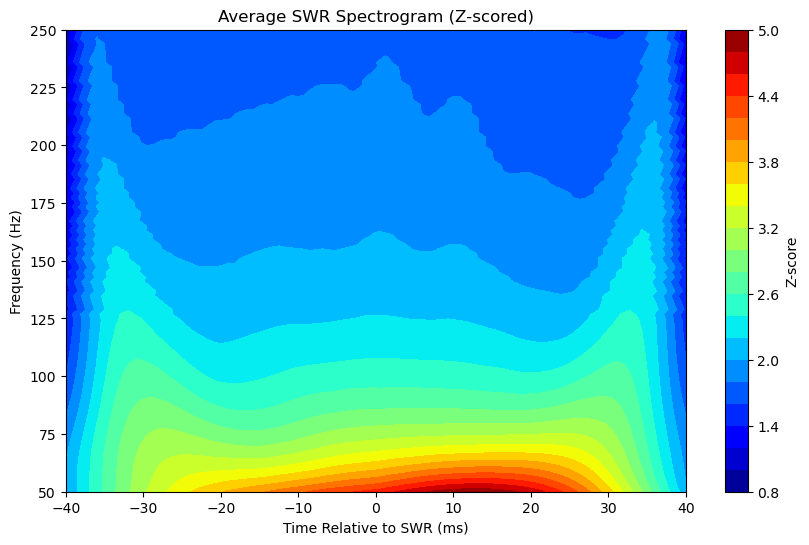

0.011472223349828397


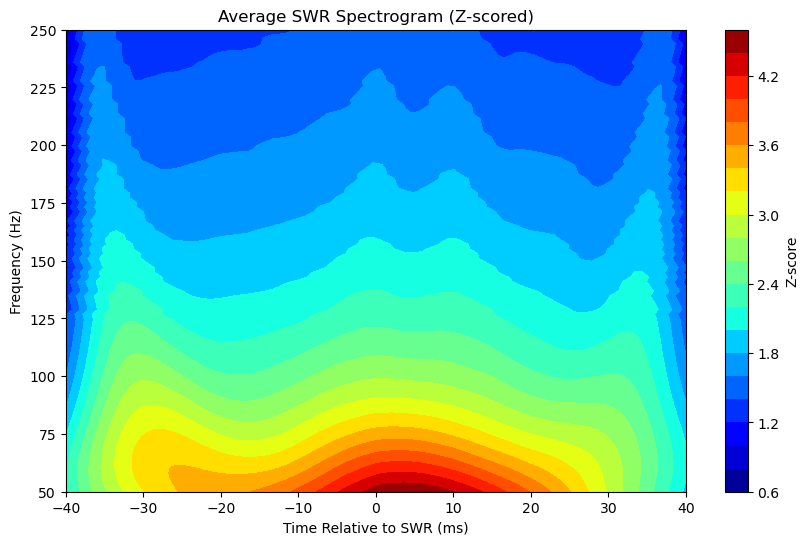

0.0115712242568682


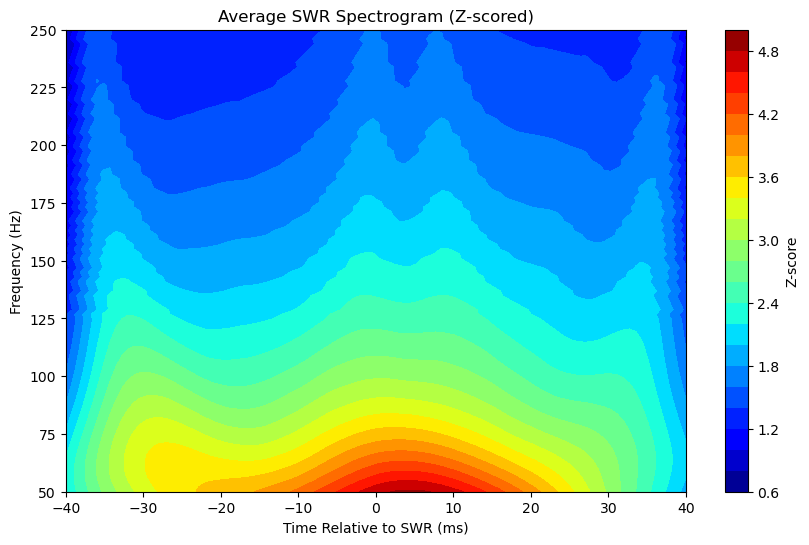

0.011534414700579119


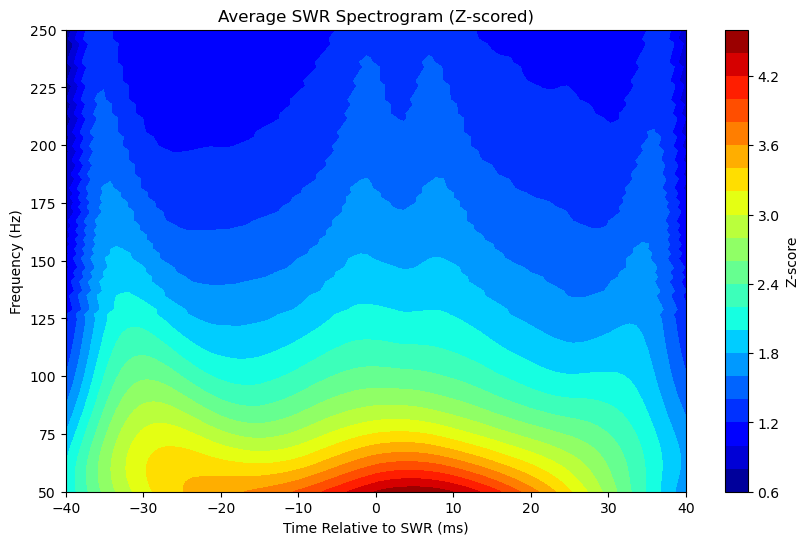

0.01150274947750964


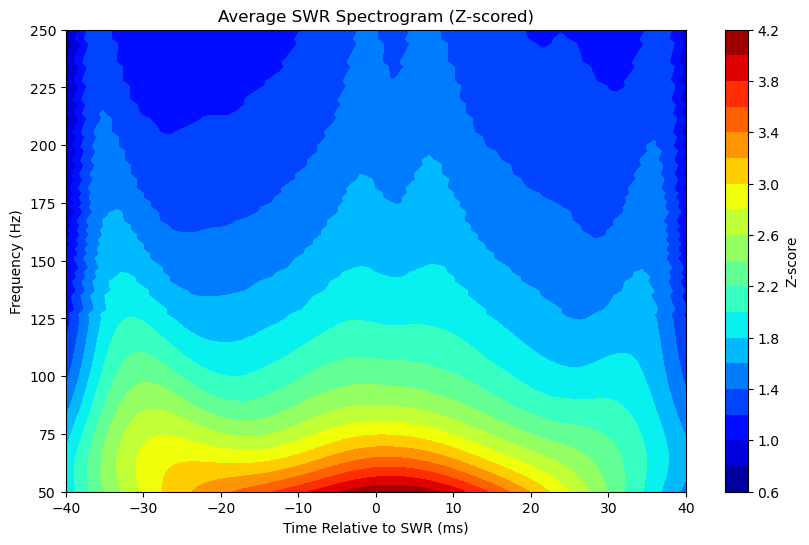

0.011689826576575451


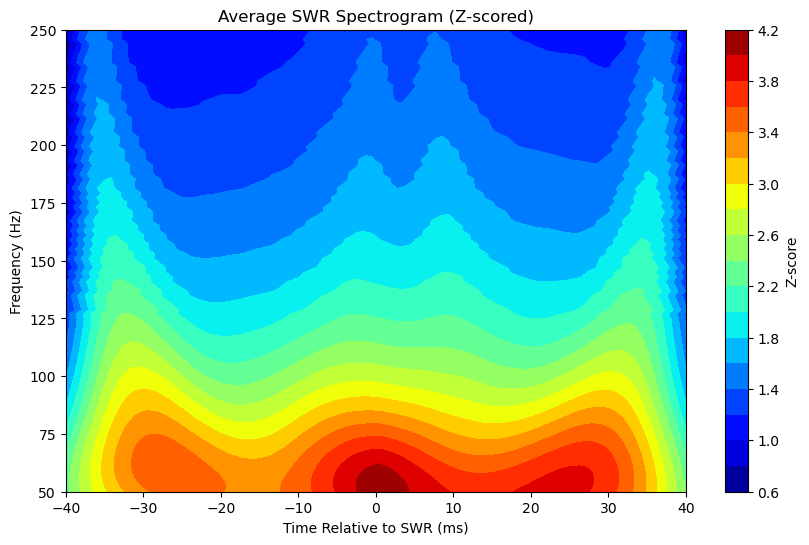

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def plot_avg_swr_spectrogram(signal_data, fs, swr_times, window_size=0.08, freq_range=(100, 250)):
    central_freq = 5.0
    scales = central_freq * fs / np.linspace(freq_range[1], freq_range[0], 100)
    window_samples = int(window_size * fs)
    half_window = window_samples // 2
    
    spectrograms = []
    for trigger in swr_times:
        center_idx = int((trigger+0.005) * fs)
        start_idx = max(0, center_idx - half_window)
        end_idx = min(len(signal_data), center_idx + half_window)
        
        windowed_signal = np.zeros(window_samples)
        signal_slice = signal_data[start_idx:end_idx]
        offset = half_window - (center_idx - start_idx)
        windowed_signal[offset:offset + len(signal_slice)] = signal_slice
        
        coefs = signal.cwt(windowed_signal, signal.ricker, scales)
        spectrograms.append(np.abs(coefs))
    
    avg_spectrogram = np.mean(spectrograms, axis=0)
    
    time_relative = np.linspace(-window_size/2, window_size/2, window_samples) * 1000
    freqs = central_freq * fs / scales
    time_mask = (time_relative >= 0) & (time_relative <= 12.5)
    freq_mask = (freqs >= 148) & (freqs <= 160)
    temp=avg_spectrogram[freq_mask][:, time_mask]
    power_0_10ms_140_160hz = np.max(temp.flatten())/np.sum(temp.flatten())
    print(power_0_10ms_140_160hz)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(time_relative, freqs, avg_spectrogram, levels=20, cmap='jet')
    plt.title('Average SWR Spectrogram (Z-scored)')
    plt.xlabel('Time Relative to SWR (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(freq_range)
    plt.colorbar(label='Z-score')
    plt.show()
    
    return power_0_10ms_140_160hz
    
#lfp = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1/63383/63383_2024-07-28_12-22-19_A_phy_k_manual/lfp_raw.npy")
# Simulate an LFP with SWR-like bursts
swr_times = [t[0] for t in pred_times]
fs = 1250
ripple_power = []
#data4ripple = lfp[:,new_chs]
data4ripple = group_5 
for i in range(8):
    signal_data = data4ripple[:,i]
    t = np.linspace(0, 1, len(signal_data) * fs, endpoint=False)

    for t_swr in swr_times:
        idx = int(t_swr * fs)
        ripple = 0.5 * np.sin(2 * np.pi * 150 * t[idx:idx+int(0.05*fs)])  # 150 Hz ripple, 50 ms
        if idx + len(ripple) <= len(signal_data):
            signal_data[idx:idx+len(ripple)] += ripple

    # Call the function
    temp_power = plot_avg_swr_spectrogram(signal_data, fs, swr_times, window_size=0.1, freq_range=(50, 250))
    ripple_power.append(temp_power)

437.33318027816574


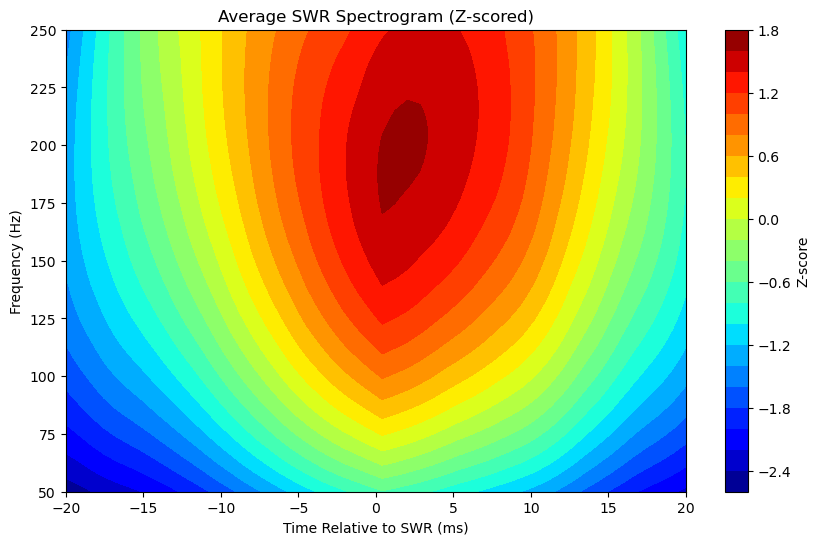

In [47]:
swr_times = [t[0] for t in pred_times]
fs = 1250
ripple_power = []
signal_data = group_5[:,i]
t = np.linspace(0, 1, len(signal_data) * fs, endpoint=False)

for t_swr in swr_times:
    idx = int(t_swr * fs)
    ripple = 0.5 * np.sin(2 * np.pi * 150 * t[idx:idx+int(0.05*fs)])  # 150 Hz ripple, 50 ms
    if idx + len(ripple) <= len(signal_data):
        signal_data[idx:idx+len(ripple)] += ripple
freq_range=(50, 250)
# Call the function


central_freq = 5.0
scales = central_freq * fs / np.linspace(freq_range[1], freq_range[0], 50)
window_samples = int(window_size * fs)
half_window = window_samples // 2

spectrograms = []
for trigger in swr_times:
    center_idx = int(trigger * fs)
    start_idx = max(0, center_idx - half_window)
    end_idx = min(len(signal_data), center_idx + half_window)
    
    windowed_signal = np.zeros(window_samples)
    signal_slice = signal_data[start_idx:end_idx]
    offset = half_window - (center_idx - start_idx)
    windowed_signal[offset:offset + len(signal_slice)] = signal_slice
    
    coefs = signal.cwt(windowed_signal, signal.ricker, scales)
    spectrograms.append(np.abs(coefs))

avg_spectrogram = np.mean(spectrograms, axis=0)

time_relative = np.linspace(-window_size/2, window_size/2, window_samples) * 1000
freqs = central_freq * fs / scales
time_mask = (time_relative >= 0) & (time_relative <= 10)
freq_mask = (freqs >= 140) & (freqs <= 160)
power_0_10ms_140_160hz = np.sum(avg_spectrogram[freq_mask][:, time_mask]**2)
print(power_0_10ms_140_160hz)
zscore_spectrogram = (avg_spectrogram - np.mean(avg_spectrogram)) / np.std(avg_spectrogram)

plt.figure(figsize=(10, 6))
plt.contourf(time_relative, freqs, zscore_spectrogram, levels=20, cmap='jet')
plt.title('Average SWR Spectrogram (Z-scored)')
plt.xlabel('Time Relative to SWR (ms)')
plt.ylabel('Frequency (Hz)')
plt.ylim(freq_range)
plt.colorbar(label='Z-score')
plt.show()


In [50]:
power_0_10ms_140_160hz 

437.33318027816574

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

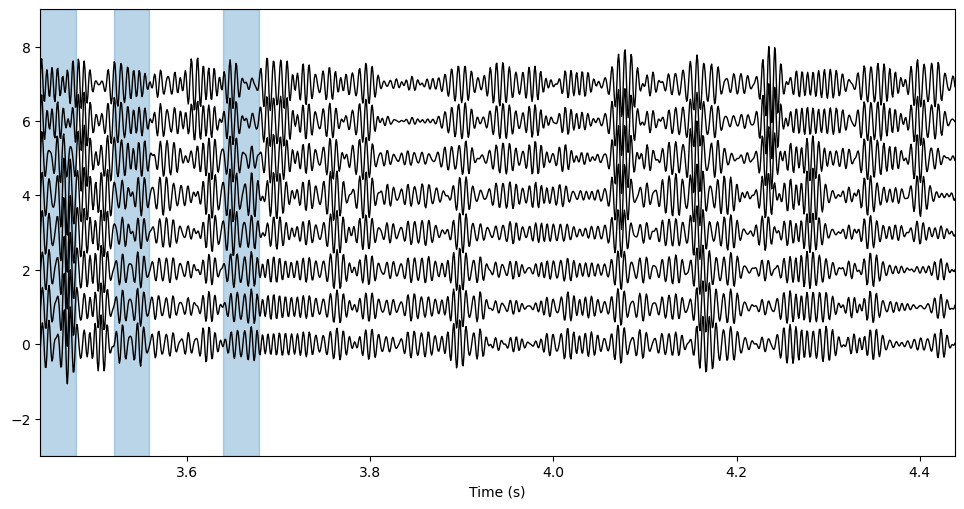

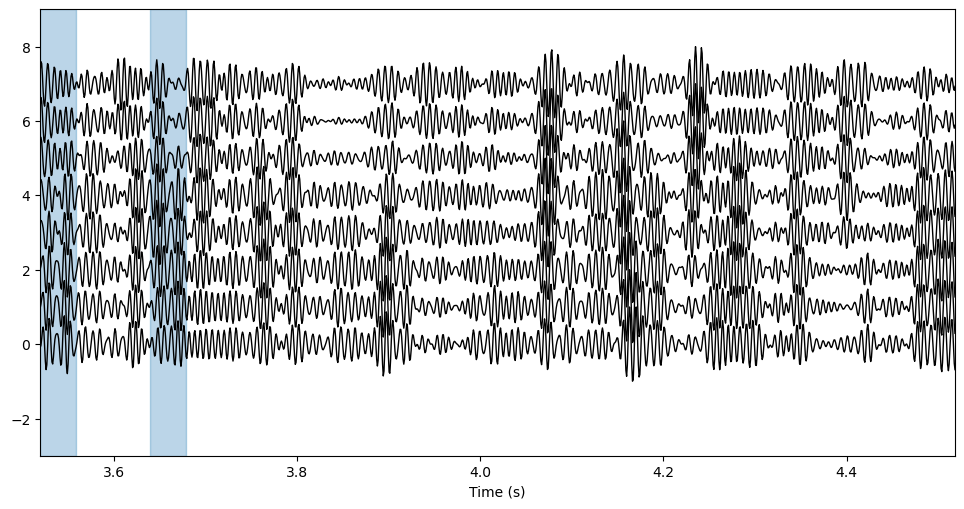

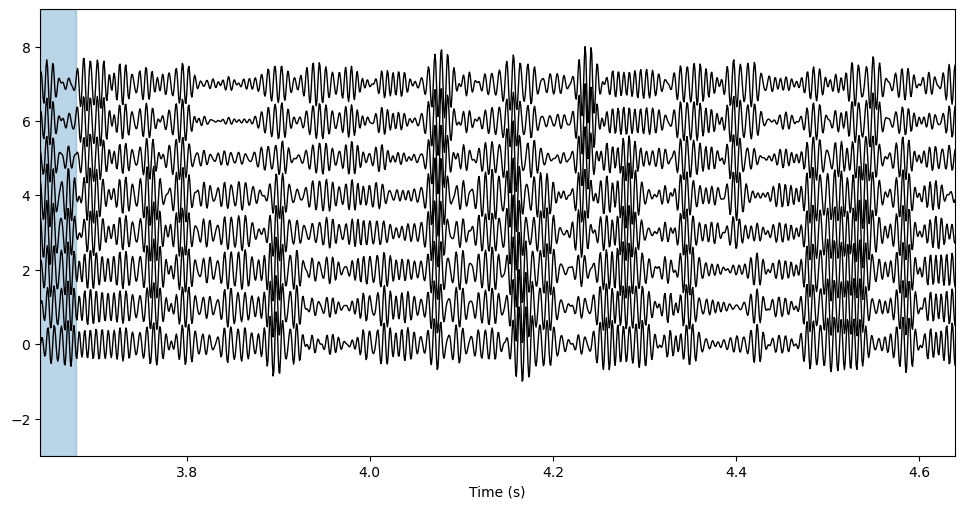

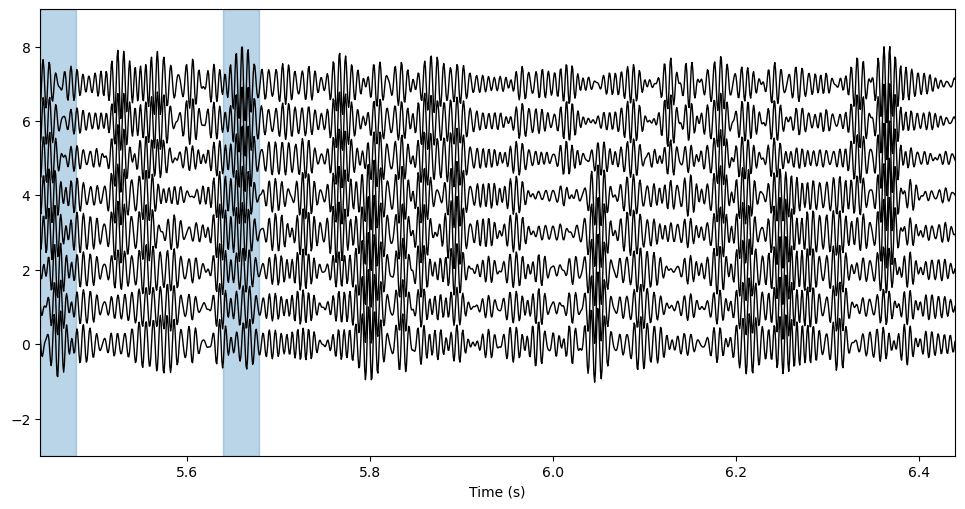

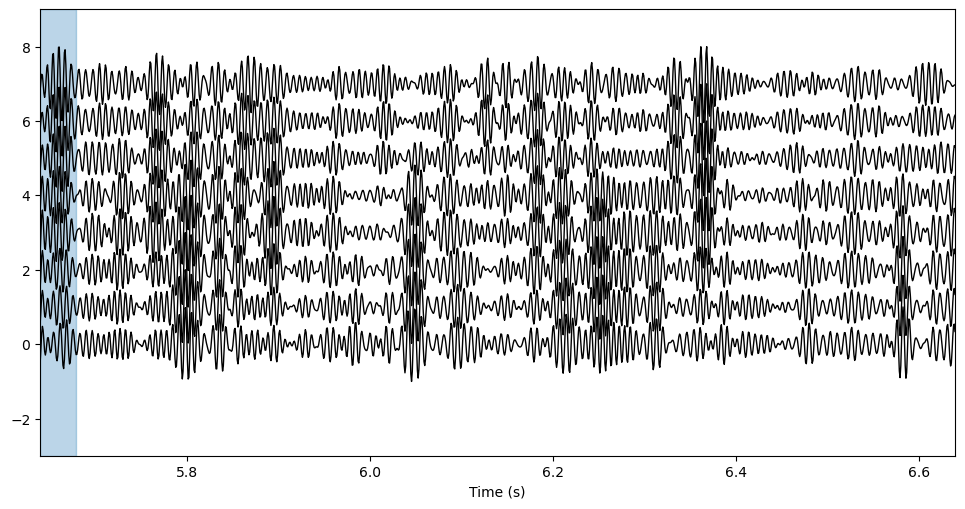

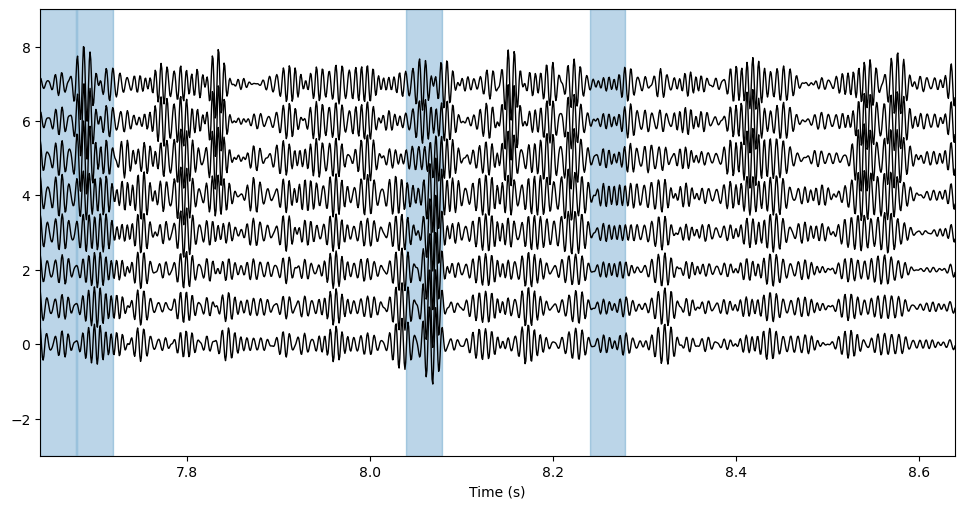

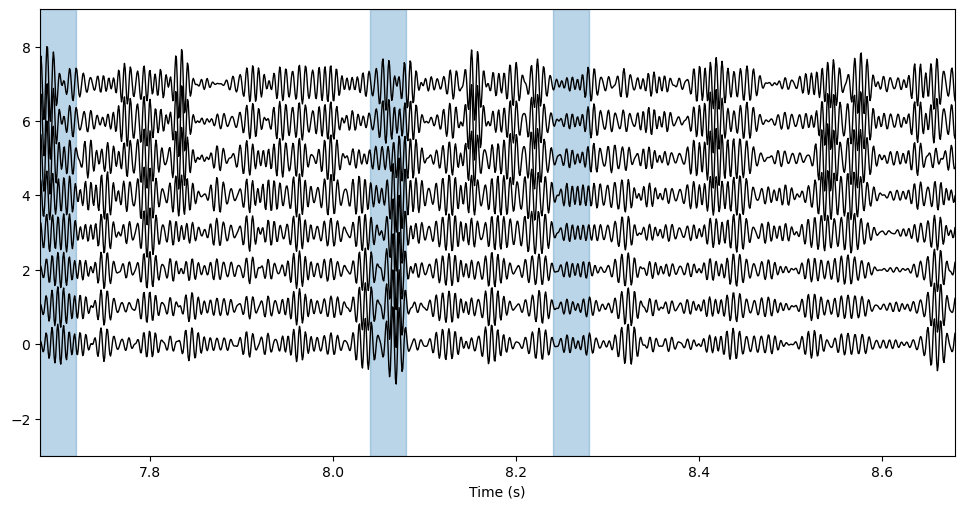

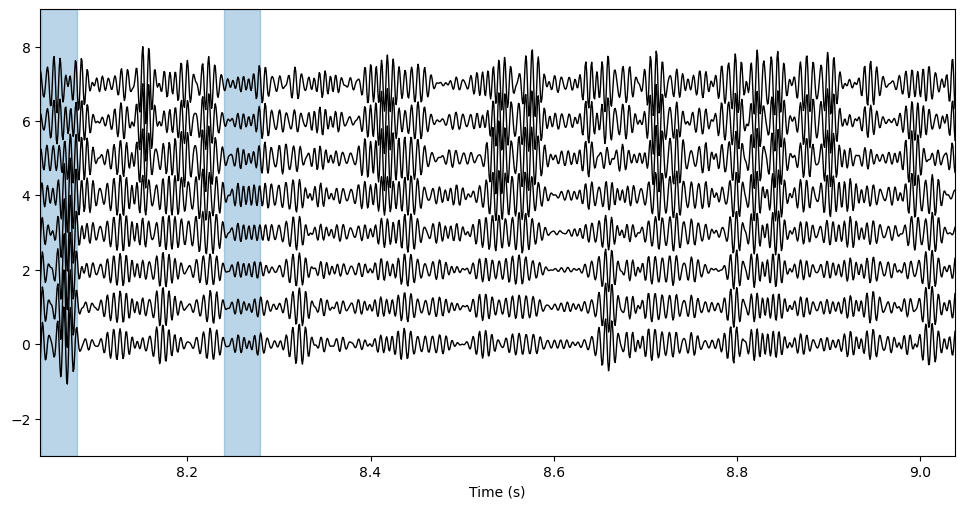

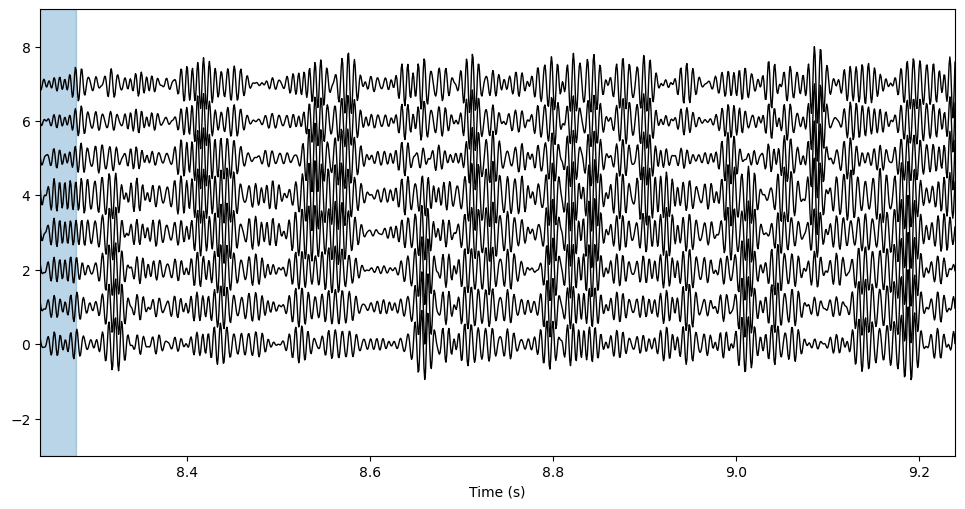

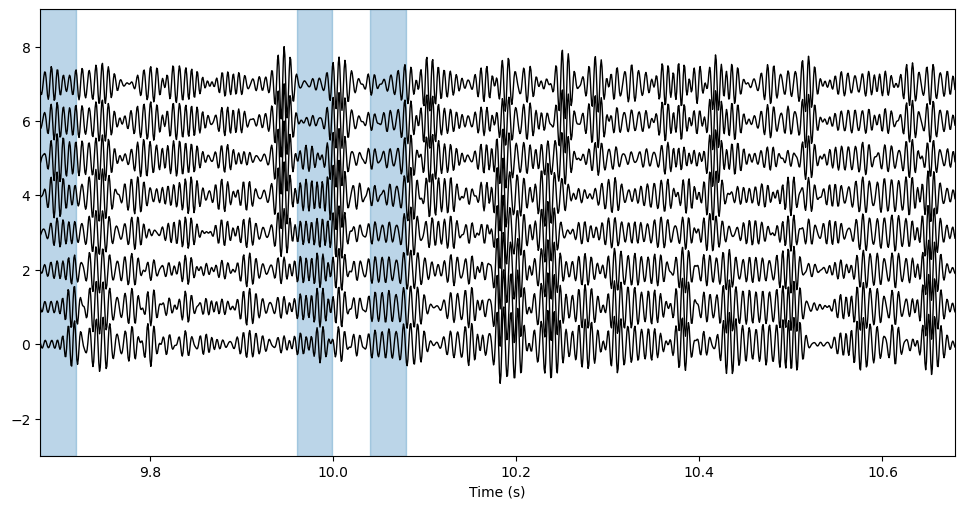

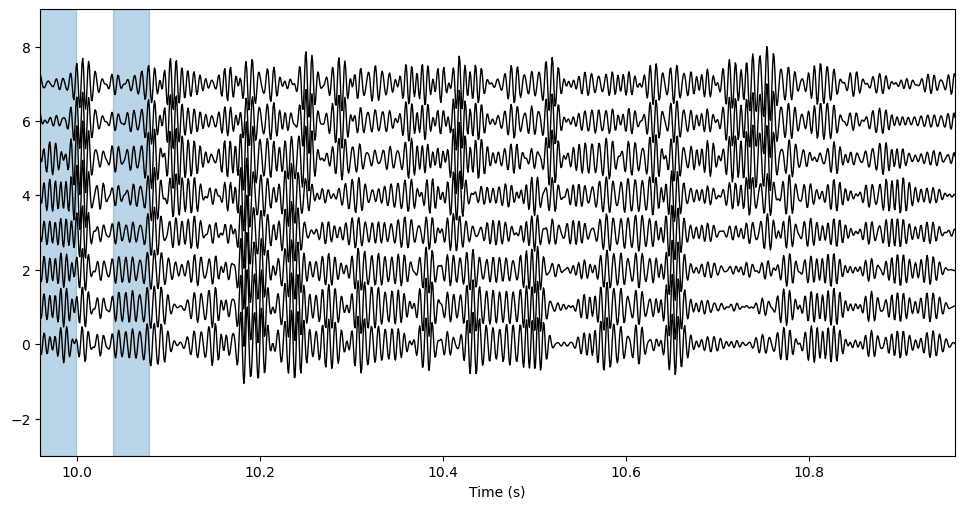

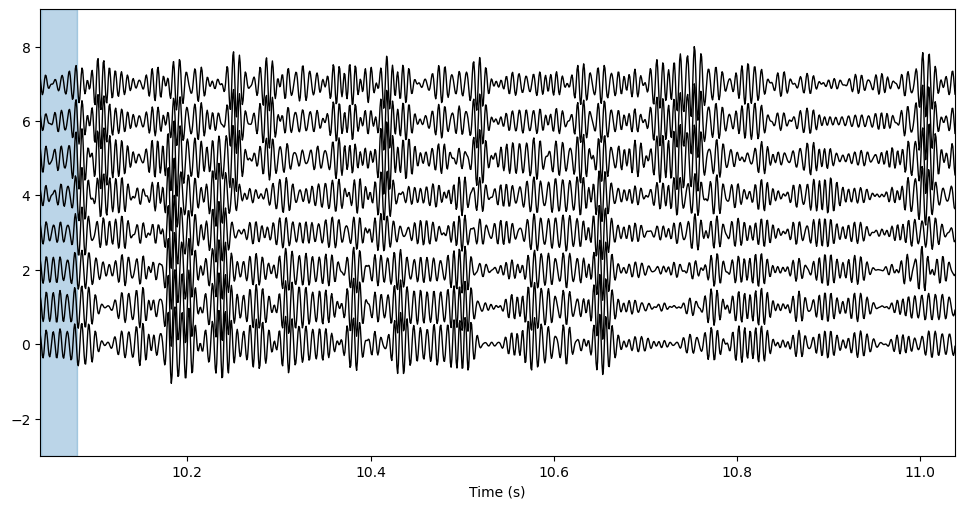

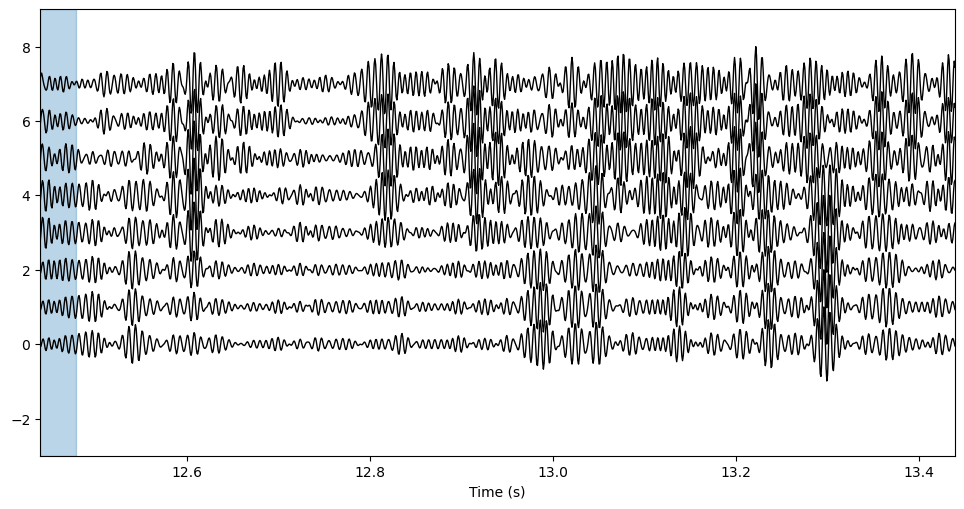

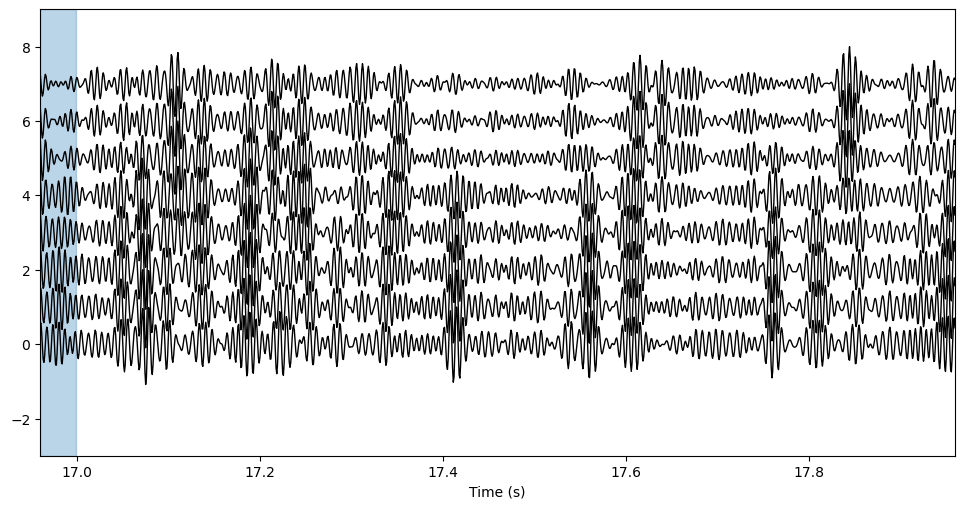

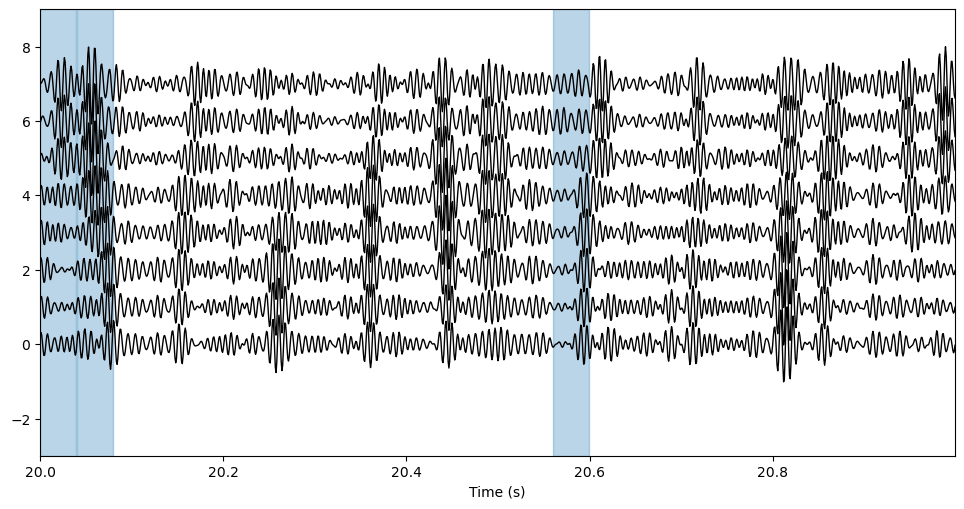

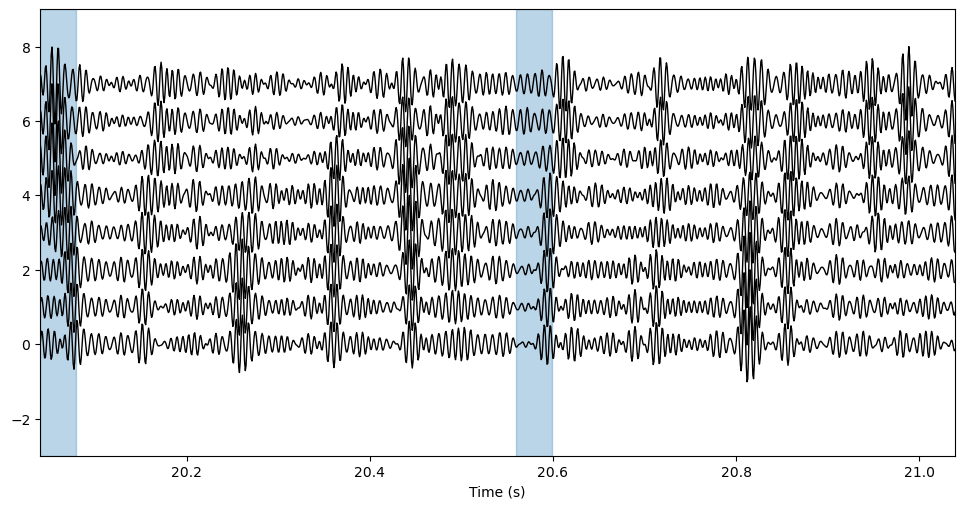

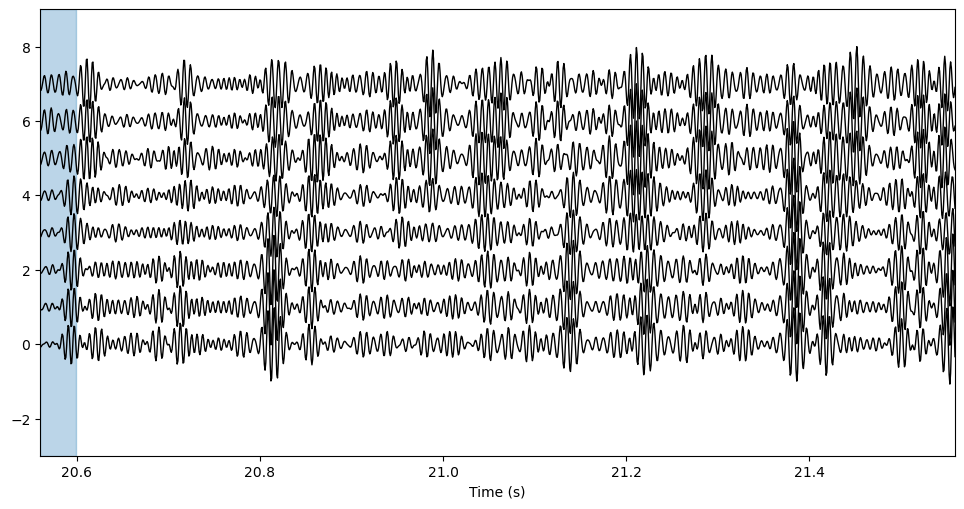

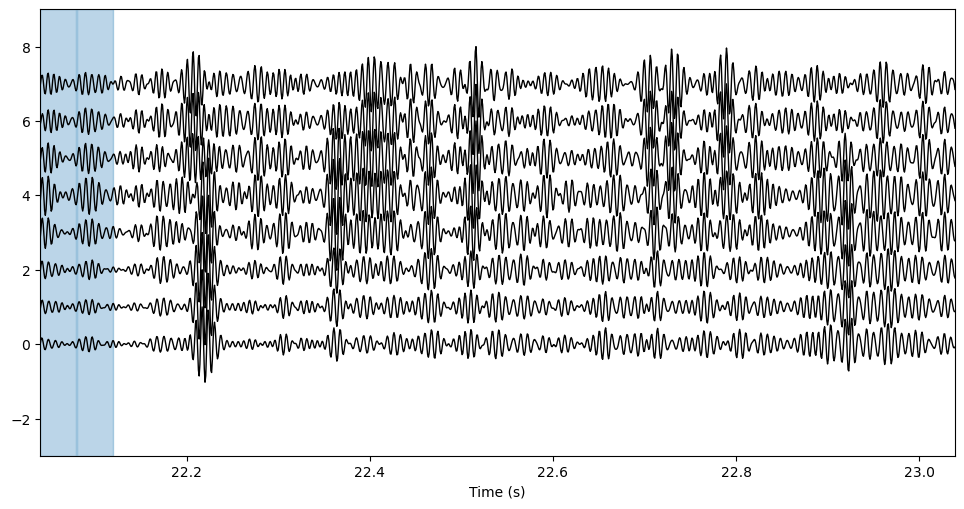

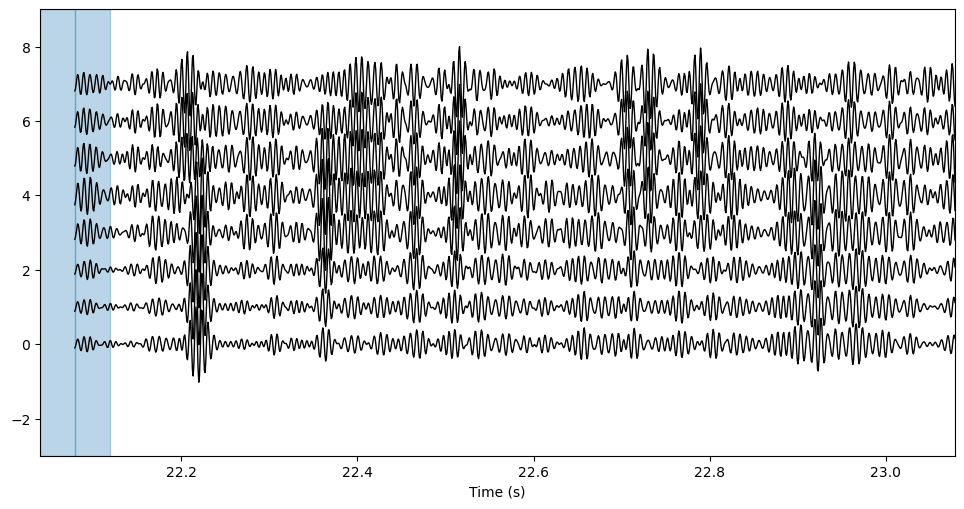

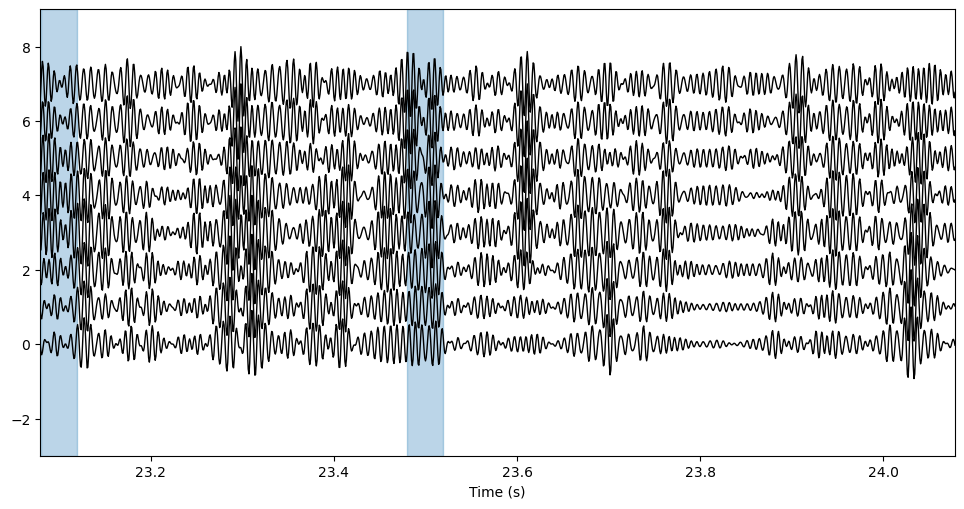

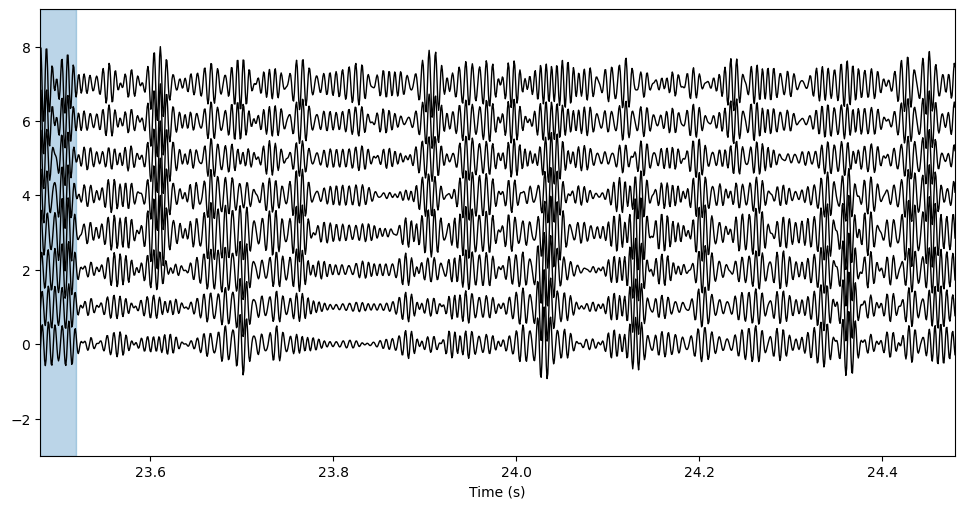

In [26]:
#@title Time (in seconds) { run: "auto", vertical-output: true, display-mode: "form" }

for t in pred_times[:,0]:
    plot_ripples(t)

In [25]:
#@markdown This is an interactive plot of the loaded data, where detected ripples are shown in blue. Data is displayed in chunks of 1 seconds and you can **move forward, backwards or jump to an specific second** using the control bar at the bottom.\
#@markdown \
#@markdown Run this cell to load the plotting method. Execute the **following** cell to use the method.

import matplotlib.pyplot as plt
  # lfp = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1/63383/63383_2024-07-25_12-57-40_A_phy_k_manual/lfp_raw.npy")
  # lfp_time = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1/63383/63383_2024-07-25_12-57-40_A_phy_k_manual/lfp_times.npy")

def plot_ripples(k):
  group_6 = lfp[:, new_chs]
  data_smooth = smooth2ripple(group_6,fs=1250, low_cut = 120, high_cut = 180)
  data= group_6  
  data_size = data.shape[0]
  data_dur = data_size / downsampled_fs
  times = np.arange(data_size) / downsampled_fs

  # if k >= times[-1]:
  #   print("Data is only %ds long!"%(times[-1]))
  #   return
  # elif k < 0:
  #   print("Please introduce a valid integer.")
  #   return

  ini_idx = int(k * downsampled_fs)
  end_idx = np.minimum(int((k+1) * downsampled_fs), data_size-1)
  pos_mat = list(range(data.shape[1]-1, -1, -1)) * np.ones((end_idx-ini_idx, data.shape[1]))

  fig = plt.figure(figsize=(9.75,5))
  ax = fig.add_subplot(1, 1, 1)
  ax.set_ylim(-3, 9)
  ax.margins(x=0)
  plt.tight_layout()
  plt.xlabel("Time (s)")


  lines = ax.plot(times[ini_idx:end_idx], data[ini_idx:end_idx, :]*1/np.max(data[ini_idx:end_idx, :], axis=0) + pos_mat, color='k', linewidth=1)

  fills = []
  for pred in pred_indexes:
      if (pred[0] >= ini_idx and pred[0] <= end_idx) or (pred[1] >= ini_idx and pred[1] <= end_idx):
          rip_ini = (pred[0]) / downsampled_fs
          rip_end = (pred[1]) / downsampled_fs
          fill = ax.fill_between([rip_ini, rip_end], [-3, -3], [9, 9], color="tab:blue", alpha=0.3)
          fills.append(fill)

  plt.show()

print("Loaded!")

Loaded!


In [ ]:
len(pred_indexes)

1229